# Synthetic Population Ensembles for Small-Area Estimation

**[Joseph V. Tuccillo](https://www.ornl.gov/staff-profile/joe-tuccillo) and [James D. Gaboardi](https://www.ornl.gov/staff-profile/james-gaboardi)** 

Oak Ridge National Laboratory

_**Disclaimer**: This manuscript has been authored by UT-Battelle, LLC, under contract DE-AC05-00OR22725 with the US Department of Energy (DOE). The US government retains and the publisher, by accepting the article for publication, acknowledges that the US government retains a nonexclusive, paid-up, irrevocable, worldwide license to publish or reproduce the published form of this manuscript, or allow others to do so, for US government purposes. DOE will provide public access to these results of federally sponsored research in accordance with the DOE Public Access Plan (https://energy.gov/downloads/doe-public-access-plan)._

## Introduction

**Synthetic populations** are realistic virtual representations of people and households within localities (e.g., neighborhoods) comprising an area of interest. They are often derived from anonymized population surveys via probabilistic estimation of survey responses among localities (**small-area weights**) based on summary statistics for those areas (e.g., people by occupation, households by dwelling type).

A key application of synthetic populations is better understanding the social composition of localities to support tasks like planning and civil engineering. To accomplish this, the small-area weights are aggregated into **small-area estimates (SAEs)** that provide cross-sectional measures of individual or residential characteristics at high spatial resolution. The SAEs are useful to answer questions like: _which neighborhoods in my city could have increased transportation costs for workers based on a combination of job type, frequency of work attendance, and travel time?_

**Synthetic population ensembles** consist of multiple plausible synthetic populations for an area relative to variability in the population survey and the model used to produce the small-area weights. The ensembles enable uncertainty quantification on the SAEs. In this example, we demonstrate the functionality of the [Likeness Python stack](https://github.com/likeness-pop) for producing SAEs related to individual and household energy affordability using data from the [American Community Survey (ACS) 2019 - 2023 5-Year Estimates](https://www.census.gov/data/developers/data-sets/acs-5year.html). We focus on the [`livelike` package](https://github.com/likeness-pop/livelike), which provides utilities for data preprocessing, model specification, and small-area estimation via the ACS [Public Use Micordata Sample (PUMS)](https://www.census.gov/programs-surveys/acs/microdata.html) (population survey) and [Summary File (SF)](https://www.census.gov/programs-surveys/acs/data/summary-file.html) (summary statistics).

## Setup

In [1]:
%load_ext watermark
%watermark

Last updated: 2025-06-13T15:24:30.315852-04:00

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.3.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit



In [2]:
import pathlib

import numpy as np
import pandas as pd
from likeness_vitals.vitals import get_censusapikey
from pymedm import PMEDM, batch, diagnostics

from livelike import acs, attribution, multi, sae
from livelike.acs import extract_geographies

%watermark -w
%watermark -iv

Watermark: 2.5.0

livelike       : 1.4.9.dev97+gc6e0c32
pymedm         : 2.2.5.dev20+g59c91c5
likeness_vitals: 1.4.5.dev2+g55eda6b
numpy          : 2.3.0
pandas         : 2.3.0



### Read Census API Key

If you have a [Census API key](https://api.census.gov/data/key_signup.html), the following cell will read it if it is:

1. stored in the same directory as this notebook
2. saved as `censusapikey.txt`.

If your Census API key is stored in another location, simply update the path accordingly. While not required, adding a key is highly recommended, as it avoids problems of request limits and timeouts. 

_**Note:** `./censusapikey.txt` is ignored by `git` and only resides locally._

In [3]:
key = get_censusapikey(pathlib.Path("."))

## Build Data

### Create PUMA ensemble

The PUMS is georeferenced to large spatial units of 100,000+ people known as [Public-Use Microdata Areas (PUMAs)](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/pumas.html). Our goal is to make SAEs for census block groups (~600-3,000 people) by statistically matching PUMS household and person records to SF estimates for block groups based on a series of _constraints_, variables of interest that are common between the PUMS and SF. 

The `livelike.acs.puma` class provides a symbolic representation of a PUMA complete with all of the inputs for this process, including:

- **Geographic constraints** from the SF for block groups and an aggregate geography, census tracts (1,200 - 8,000 people), used by the model. 
- **Individual-level constraints** based on harmonizing PUMS responses to corresponding SF variables.
- **PUMS weights** estimating how representative each PUMS residence (housing unit or [group quarters](https://censusreporter.org/topics/group-quarters/)) is of the PUMA as a whole. 

The last of these, the PUMS weights, are the building block for the synthetic population ensembles. The PUMS contains a baseline (or "full") sample weight and a series of alternative _replicate_ weights representing sampling variability. Substituting the replicate weights for the full weights produces different estimates of the small-area weights that are combined into an ensemble.

This example focuses on the [Knoxville City Central, TN PUMA](https://censusreporter.org/profiles/79500US4701501-knoxville-city-central-puma-tn/) using the ACS 5-Year 2023 vintage:

In [4]:
year = 2023
puma = "4701501"

Before we create the PUMAs, we need to specify our model constraints. A custom selection can be made by passing a `dict` with subject names organized by theme. A complete list of constraint subjects by theme is available [here](https://github.com/likeness-pop/livelike/blob/develop/livelike/data/constraints.csv).

In [5]:
sel = {
    "universe": True,  # total pop, total housing units, total group quarters, etc
    "worker": [
        "sexocc",  # sex by occupation
        "worked",  # hours worked per week
    ],
    "mobility": [
        "commute",  # commute mode
        "travel",  # commute travel time
        "veh_occ",  # commute drive type
    ],
    "demographic": [
        "sex_age",  # sex by age
        "hhtype",  # household type (family/nonfamily, marital status)
        "hhtype_hhsize,",  # household type by household size
    ],
    "social": [
        "race",  # race
        "hsplat",  # Hispanic/Latino ethnicity
    ],
    "economic": [
        "hhinc",  # household income
        "ipr",  # ratio of personal income to poverty line
    ],
    "housing": [
        "units",  # dwelling type/units in structure
        "year_built",  # year dwelling built
        "owncost",  # owner home costs as pct of monthly income
        "rentcost",  # renter home costs as pct of monthly income
        "hhf",  # house heating fuel
    ],
}

We then create multiple `livelike.acs.puma()` objects based on the replicates, via the `livelike.multi` module:

In [6]:
# takes a few minutes
mpu = multi.make_replicate_pumas(
    puma,
    year=year,
    constraints_selection=sel,
    # nreps=29, # ensemble of 30
    # nreps=9, # ensemble of 10
    nreps=4,  # ensemble of 5
    censusapikey=key,
    cache_folder="replicate_demo_cache",
    keep_intermediates=True,
)

In [7]:
mpu

{'4701501_4': <livelike.acs.puma at 0x3230d1f70>,
 '4701501_3': <livelike.acs.puma at 0x320fdabd0>,
 '4701501_2': <livelike.acs.puma at 0x31e9d4fe0>,
 '4701501_1': <livelike.acs.puma at 0x32200a390>,
 '4701501_0': <livelike.acs.puma at 0x32340f0b0>}

Keys ending with `_0` denote the `livelike.acs.puma` instance created on the full PUMS weights.

## Estimate Small-Area Weights Ensemble

To estimate the small-area weights, we solve multiple optimization problems based on the `mpu` inputs using the [Penalized Maximum-Entropy Dasymetric Modeling (P-MEDM)](https://www.tandfonline.com/doi/abs/10.1080/00045608.2013.843439) method. Likeness contains both a Python-native P-MEDM solver, [`pymedm`](https://github.com/likeness-pop/pymedm), and one that uses the [original R/C++ implementation of the model](https://bitbucket.org/nnnagle/pmedmrcpp/src), [`pmedm_legacy`](https://github.com/likeness-pop/pmedm-legacy). In this case, we use `pymedm`, which is optimized for GPU-enabled hardware via [JAX](https://github.com/jax-ml/jax).

In [8]:
# takes a few minutes
pmds = batch.batch_solve(mpu)

In [9]:
pmds

{'4701501_4': <pymedm.pmedm.PMEDM at 0x335f892e0>,
 '4701501_3': <pymedm.pmedm.PMEDM at 0x335f89130>,
 '4701501_2': <pymedm.pmedm.PMEDM at 0x335f8a390>,
 '4701501_1': <pymedm.pmedm.PMEDM at 0x32340fbc0>,
 '4701501_0': <pymedm.pmedm.PMEDM at 0x335f8b620>}

### Diagnostics

As a quick diagnostic, we measure the proportion of synthetic constraint estimates fitting the ACS 90% margins of error (MOEs), or the "moe_fit_rate":

In [10]:
mfrs = []
for p in mpu:
    mfr = diagnostics.moe_fit_rate(
        mpu[p].est_ind, mpu[p].est_g2, mpu[p].se_g2, pmds[p].almat
    )
    mfrs += [mfr["moe_fit_rate"]]

In [11]:
pd.Series(mfrs).describe()

count    5.000000
mean     0.997779
std      0.000248
min      0.997453
25%      0.997693
50%      0.997741
75%      0.997885
max      0.998125
dtype: float64

Our minimum MOE Fit Rate is well above 99% (~0.997), indicating that the synthetic constraint estimates conform closely with those published in the ACS SF.

#### Inspect Small-Area Weights

The small-area weights provide count estimates of each PUMS residence (rows) by block group (columns): 

In [12]:
# base solution
saw_0 = pd.DataFrame(
    pmds[f"{puma}_0"].almat,
    index=pmds[f"{puma}_0"].serial.tolist(),
    columns=pmds[f"{puma}_0"].topo.g2.tolist(),
)
# preview first 5 block groups
saw_0.iloc[:, :5]

,470930001001,470930001002,470930008001,470930008002,470930008003
2019GQ0001260,2.280450,0.019705,0.019491,0.030060,0.118358
2019GQ0003543,0.229591,0.027575,0.012469,0.094568,0.528426
2019GQ0004171,0.830382,0.006867,0.019849,0.048133,0.149539
2019GQ0012722,0.378296,0.016941,0.007594,0.013056,0.024916
2019GQ0013655,0.791657,0.051715,0.199074,0.053124,0.141887
...,...,...,...,...,...
2023HU1444722,0.001381,0.000541,0.009763,0.023537,0.004656
2023HU1444747,0.810086,0.036281,0.248462,0.014442,0.012271
2023HU1451688,0.003486,0.002954,0.000598,0.001655,0.278113
2023HU1455500,0.173057,0.017357,0.021636,0.018443,0.140569


In [13]:
# replicate 1
saw_1 = pd.DataFrame(
    pmds[f"{puma}_1"].almat,
    index=pmds[f"{puma}_1"].serial.tolist(),
    columns=pmds[f"{puma}_1"].topo.g2.tolist(),
)
# preview first 5 block groups
saw_1.iloc[:, :5]

,470930001001,470930001002,470930008001,470930008002,470930008003
2019GQ0001260,2.852931,0.023894,0.034322,0.059294,0.257650
2019GQ0003543,0.442778,0.054404,0.025145,0.193376,1.088277
2019GQ0004171,0.769770,0.005940,0.019459,0.042345,0.135650
2019GQ0012722,0.358597,0.018472,0.010908,0.021397,0.028086
2019GQ0013655,1.398831,0.086658,0.467120,0.097594,0.286291
...,...,...,...,...,...
2023HU1444722,0.002295,0.000972,0.013798,0.036830,0.007638
2023HU1444747,1.066529,0.026798,0.295618,0.020130,0.015878
2023HU1451688,0.002775,0.002537,0.000462,0.001693,0.258211
2023HU1455500,0.210697,0.016467,0.014425,0.019195,0.140624


Note the slight differences in the small-area weights between the two versions of `saw`:

- In the base case, we estimate (~0.94) residences like PUMS `2023HU1444747` in block group `470930001001` but (~1.18) for replicate 1. 
- In the base case, we estimate (~0.49) residences like PUMS `2019GQ0003543` in block group `470930008003` but more (~1.07) for replicate 1.

These differences may seem like splitting hairs, but when we consider **_segments_** consisting of multiple people or residences within the PUMA population with common characteristics, they add up. This forms the basis for the SAE procedure, which we will explore next.

### Small-Area Estimation

#### Get block group boundaries

These are fetched internally from the [TIGER Web Mapping Service](https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_main.html) via the `livelike.acs` module. We will use these to visualize the SAE results.

<Axes: >

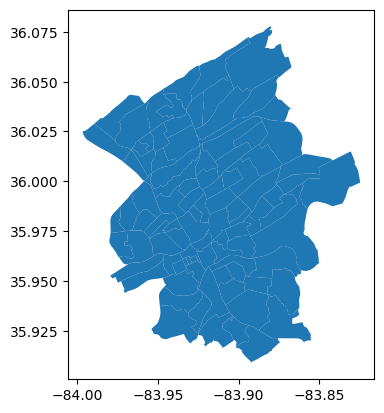

In [14]:
geoids = mpu[f"{puma}_0"].est_g2.index
geo = acs.extract_geographies(2023, targets=geoids, geo="bg")
geo.plot()

#### Household Scenario: Home Energy Affordability

Suppose we are interested in a home energy affordability scenario based on the following criteria:

- Home uses electricity or utility gas
- Single-family detached home
- Older home built pre-1950
- Annual household income <$50k
- Occupant housing costs >30% of monthly income

##### Define attributes

In order to define our household segments on the criteria of interest, we must first generate some attributes for querying the PUMS records. These are derived from the P-MEDM constraints via the `livelike.attribution` module by instantiating a PUMA as `livelike.acs.puma(keep_intermediates=True)` or `livelike.multi.make_relicate_pumas(keep_intermediates=True)`.

In [15]:
atts_hh = attribution.build_attributes(
    mpu[f"{puma}_0"],
    "household",
    [
        "housing_costs_pct_income",
        "house_heating_fuel",
        "dwelling_type",
        "year_dwelling_built",
        "household_income",
    ],
)

In [16]:
atts_hh

,housing_costs_pct_income,house_heating_fuel,dwelling_type,year_dwelling_built,household_income
SERIALNO,,,,,
2019GQ0001260,,,,,
2019GQ0003543,,,,,
2019GQ0004171,,,,,
2019GQ0012722,,,,,
2019GQ0013655,,,,,
...,...,...,...,...,...
2023HU1444722,10to14.9,electricity,single_fam_detach,50_59,50_60k
2023HU1444747,25to29.9,electricity,GE50_unit,60_69,25_30k
2023HU1451688,more50,utility_gas,single_fam_detach,L1939,10_15k


Blank entries (`''`) represent cases that are out of universe for a given variable. For example, the first five entries here are group quarters (shown by the `GQ` in the index values), which means they are not described by any of the housing unit-specific attributes used here.

Now we can subset cases from `atts_hh` matching our segment characteristics:

In [17]:
seg_hh = atts_hh[
    (atts_hh.house_heating_fuel.isin(["electricity", "utility_gas"]))
    & (
        atts_hh.housing_costs_pct_income.isin(
            ["30to34.9", "35to39.9", "40to49.9", "more50"]
        )
    )
    & (atts_hh.dwelling_type == "single_fam_detach")
    & (atts_hh.year_dwelling_built.isin(["L1939", "40_49"]))
    & (
        atts_hh.household_income.isin(
            [
                "L10k",
                "10_15k",
                "20_25k",
                "25_30k",
                "30_35k",
                "35_40k",
                "40_45k",
                "45_50k",
            ]
        )
    )
]

In [18]:
# preview records matching segment characteristics
seg_hh.head(10)

,housing_costs_pct_income,house_heating_fuel,dwelling_type,year_dwelling_built,household_income
SERIALNO,,,,,
2019HU0090660,35to39.9,electricity,single_fam_detach,40_49,20_25k
2019HU0211443,30to34.9,electricity,single_fam_detach,40_49,45_50k
2019HU0321259,40to49.9,utility_gas,single_fam_detach,40_49,25_30k
2019HU0479532,30to34.9,electricity,single_fam_detach,40_49,25_30k
2019HU0480499,40to49.9,electricity,single_fam_detach,L1939,40_45k
2019HU0517289,more50,utility_gas,single_fam_detach,40_49,10_15k
2019HU0519792,more50,electricity,single_fam_detach,L1939,10_15k
2019HU0535812,30to34.9,utility_gas,single_fam_detach,L1939,35_40k
2019HU0787972,more50,utility_gas,single_fam_detach,40_49,L10k


#### Compute SAEs

The SAE procedure is wrapped by `livelike.sae.estimate()`. The estimate is made by passing the index values for the segment of interest as the `serial` parameter. To facilitate comparison among block groups, we also set `normalize=True` to generate proportional estimates for each block group.

In [19]:
seg_hh_est_ = sae.estimate(
    mpu,
    pmds,
    seg_hh.index,
    normalize=True,
)

In [20]:
seg_hh_est_

,rep0,rep1,rep2,rep3,rep4
GEOID,,,,,
470930001001,0.000945,0.000866,0.000603,0.000909,0.000842
470930001002,0.000773,0.000870,0.000480,0.000534,0.000840
470930008001,0.003599,0.003494,0.004060,0.004134,0.003176
470930008002,0.005016,0.004997,0.005939,0.004940,0.006302
470930008003,0.013362,0.012236,0.014476,0.015409,0.013882
...,...,...,...,...,...
470930069022,0.004092,0.004842,0.005740,0.004345,0.006041
470930069031,0.001748,0.002332,0.001752,0.001138,0.001797
470930069032,0.007318,0.007427,0.006497,0.006095,0.008729


The result `seg_hh_est_` consists of all estimates across the ensemble. To aggregate it into point estimates with uncertainty, use `sae.summarize()`:

In [21]:
seg_hh_est = sae.summarize(seg_hh_est_)

In [22]:
seg_hh_est

,est,se,moe90_lower,moe90_upper,cv
GEOID,,,,,
470930001001,0.000833,0.000135,0.000612,0.001055,0.161491
470930001002,0.000700,0.000180,0.000403,0.000996,0.257541
470930008001,0.003692,0.000402,0.003032,0.004353,0.108751
470930008002,0.005439,0.000636,0.004393,0.006485,0.116918
470930008003,0.013873,0.001190,0.011915,0.015831,0.085791
...,...,...,...,...,...
470930069022,0.005012,0.000853,0.003609,0.006415,0.170175
470930069031,0.001754,0.000423,0.001058,0.002449,0.241231
470930069032,0.007213,0.001014,0.005545,0.008882,0.140625


Our result has the columns:

- `est` : point estimate (mean across ensemble)
- `se` : standard error across ensemble
- `moe90_lower` / `moe90_upper` : the lower and upper bound 90% margins of error (MOEs) on the point estimate. For example, based on the MOEs, we would roughly estimate between ~3.5% - ~5% of households being in `seg_hh` for block group `470930070001`.
- `cv` : coefficent of variation, the degree of uncertainty in the estimate defined by `se / est`.

##### Visualize results

<Axes: >

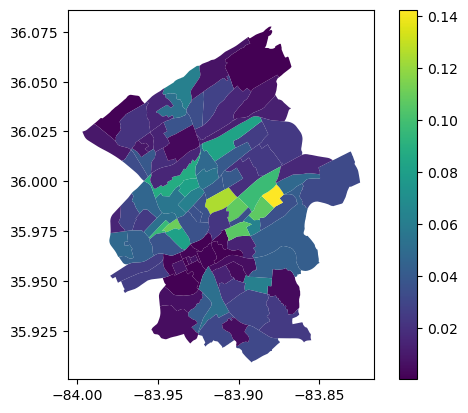

In [23]:
# estimates
geo.join(seg_hh_est).plot("est", legend=True)

In [24]:
# # uncomment for interactive map
# geo.join(seg_hh_est).explore("est", tiles="cartodb positron")

<Axes: >

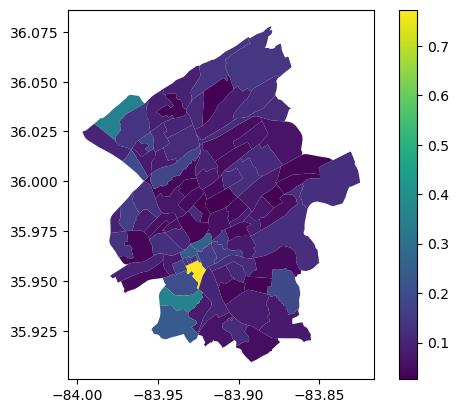

In [25]:
# coefficient of variation
geo.join(seg_hh_est).plot("cv", legend=True)

In [26]:
# # uncomment for interactive map
# geo.join(seg_hh_est).explore("cv", tiles="cartodb positron")

<Axes: xlabel='est', ylabel='cv'>

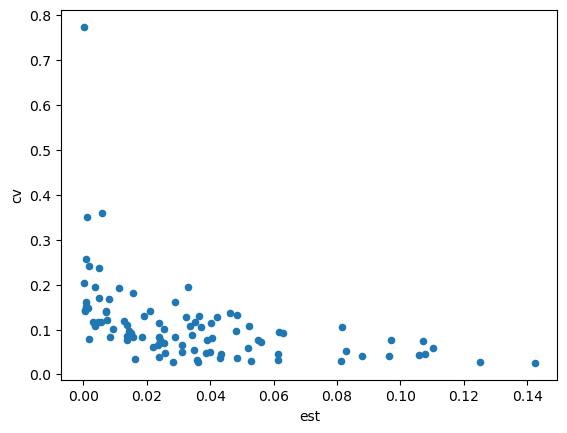

In [27]:
# compare estimates with coeffs of variation
seg_hh_est.loc[:, ["est", "cv"]].plot.scatter("est", "cv")

In general, the coefficient of variation will be highest for very small proportional estimates, then level out as they become larger. 

_**Note** that we are using a reduced number of replicates in our ensemble for demonstrative purposes. For more robust estimates, [an ensemble of least 30](https://www.sciencedirect.com/science/article/pii/S0143622822002156) is recommended._

#### Person-level Scenario: Transportation Affordability

As we alluded to in the introduction we might also be interested in understanding energy affordability problems where transportation is cost-prohibitive. We could define such a scenario at the person level as:

- Works 35+ hours per week
- Drives alone to work
- Commute time >30min
- In an occupation with low telework potential
- Annual personal income below poverty line

#### Define attributes

Since the concept of "low telework potential" occupations isn't represented directly in the ACS, we represent it using categories identified in a microsimulation exercise conducted by [Tuccillo et al. (2023)](https://www.sciencedirect.com/science/article/pii/S0143622822002156):

In [28]:
atts_pr = attribution.build_attributes(
    mpu[f"{puma}_0"],
    "person",
    [
        "commute_time_m",
        "commute_drive_type",
        "hours_worked",
        "occupation",
        "income_to_poverty_ratio",
    ],
)

In [29]:
atts_pr

commute_time_m commute_drive_type hours_worked  \
SERIALNO      SPORDER                                                  
2019GQ0001260 1                10.14                            GE35   
2019GQ0003543 1                                                        
2019GQ0004171 1                                                        
2019GQ0012722 1                  L10                           15.34   
2019GQ0013655 1                                                        
...                              ...                ...          ...   
2023HU1444747 1                                                        
              2                                                        
2023HU1451688 1                                                        
2023HU1455500 1                30.34                            GE35   
2023HU1456828 1                                                        

                      occupation income_to_poverty_ratio  
SERIALNO      SPORDER                                     
2019GQ0001260 1              prd                 100_124  
2019GQ0003543 1                                           
2019GQ0004171 1                                           
2019GQ0012722 1              cmp                          
2019GQ0013655 1                                           
...                          ...                     ...  
2023HU1444747 1                                  050_099  
              2                                  100_124  
2023HU1451688 1                                  050_099  
2023HU1455500 1              off                   GE200  
2023HU1456828 1                                  050_099  

[6489 rows x 5 columns]

In [30]:
low_telework_occs = [
    "mgmt",  # management
    "eng",  # engineering/architecture
    "ent",  # arts/entertainment/recreation
    "med",  # medical
    "med.tech",  # medical tech
    "hls",  # healthcare support
    "prt",  # protective services
    "law.enf",  # law enforcement
    "eat",  # food services
    "cln",  # cleaning
    "prs",  # personal care services
    "sal",  # sales
    "off",  # office/administrative support
    "fff",  # forestry, fishing, and farming
    "con_ext",  # construction/extractive services
    "rpr",  # repair
    "prd",  # goods production
    "trn.mat",  # transportation and material moving
]

In [31]:
# preview records matching segment characteristics
seg_pr = atts_pr[
    (atts_pr.commute_time_m.isin(["30.34", "35.44", "45.59", "GE60"]))
    & (atts_pr.commute_drive_type == "drove_alone")
    & (atts_pr.hours_worked == "GE35")
    & (atts_pr.occupation.isin(low_telework_occs))
    & (atts_pr.income_to_poverty_ratio.isin(["L050", "050_099"]))
]
seg_pr

,,commute_time_m,commute_drive_type,hours_worked,occupation,income_to_poverty_ratio
SERIALNO,SPORDER,,,,,
2019HU0088360,5,30.34,drove_alone,GE35,prs,050_099
2019HU0588740,1,30.34,drove_alone,GE35,off,050_099
2019HU0831655,1,35.44,drove_alone,GE35,prd,050_099
2020HU0832907,1,GE60,drove_alone,GE35,prs,L050
2021HU0170125,2,30.34,drove_alone,GE35,trn.mat,050_099
2021HU0611276,1,30.34,drove_alone,GE35,mgmt,L050
2021HU0698036,1,45.59,drove_alone,GE35,med.tech,050_099
2021HU0882269,1,30.34,drove_alone,GE35,fff,L050
2022GQ0045439,1,GE60,drove_alone,GE35,cln,050_099


#### Compute SAEs

In [32]:
# person, prop ests, full ensemble
seg_pr_est_ = sae.estimate(
    mpu,
    pmds,
    seg_pr.index,
    normalize=True,
)

In [33]:
seg_pr_est_

,rep0,rep1,rep2,rep3,rep4
GEOID,,,,,
470930001001,0.000812,0.001004,0.001034,0.001271,0.000573
470930001002,0.000814,0.001082,0.001139,0.000702,0.000943
470930008001,0.000190,0.000259,0.000376,0.000210,0.000133
470930008002,0.001462,0.001759,0.001651,0.002308,0.000989
470930008003,0.001980,0.001835,0.001522,0.001535,0.002392
...,...,...,...,...,...
470930069022,0.000210,0.000314,0.000608,0.000316,0.000307
470930069031,0.000683,0.000502,0.000522,0.000730,0.000837
470930069032,0.000395,0.000664,0.000266,0.000357,0.000293


In [34]:
# consolidate results
seg_pr_est = sae.summarize(seg_pr_est_)
seg_pr_est

,est,se,moe90_lower,moe90_upper,cv
GEOID,,,,,
470930001001,0.000939,0.000262,0.000509,0.001369,0.278655
470930001002,0.000936,0.000182,0.000636,0.001236,0.194558
470930008001,0.000234,0.000092,0.000083,0.000384,0.391602
470930008002,0.001634,0.000479,0.000846,0.002421,0.292938
470930008003,0.001853,0.000360,0.001261,0.002444,0.194175
...,...,...,...,...,...
470930069022,0.000351,0.000150,0.000103,0.000598,0.428876
470930069031,0.000655,0.000142,0.000421,0.000888,0.216732
470930069032,0.000395,0.000159,0.000134,0.000656,0.401397


#### Visualize results

<Axes: >

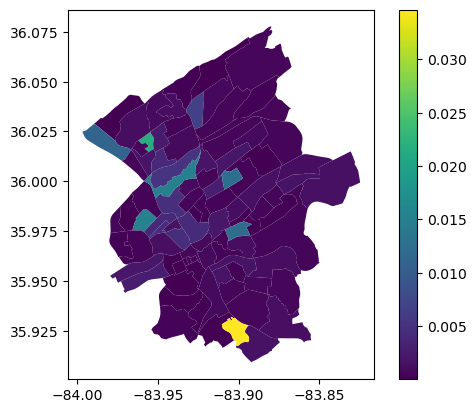

In [35]:
# point estimates
geo.join(seg_pr_est).plot("est", legend=True)

In [36]:
# # uncomment for interactive map
# geo.join(seg_pr_est).explore("est", tiles="cartodb positron")

<Axes: >

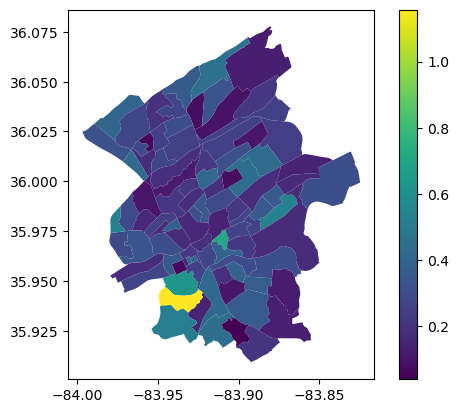

In [37]:
# coefficients of variation
geo.join(seg_pr_est).plot("cv", legend=True)

In [38]:
# # uncomment for interactive map
# geo.join(seg_pr_est).explore("cv", tiles="cartodb positron")

<Axes: xlabel='est', ylabel='cv'>

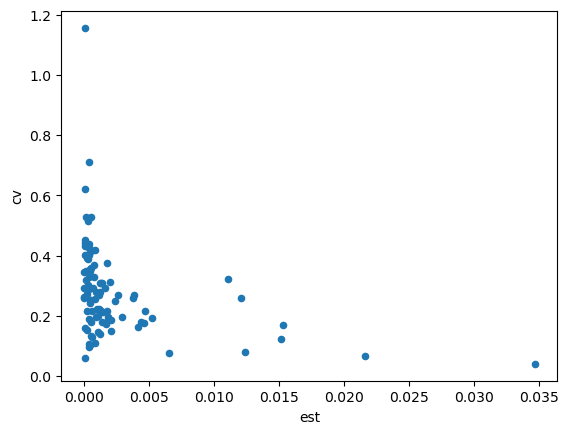

In [39]:
# compare estimates with coeffs of variation
seg_pr_est.loc[:, ["est", "cv"]].plot.scatter("est", "cv")

## References

1. Tuccillo, J., & Gaboardi, J. (2022). Likeness: a toolkit for connecting the social fabric of place to human dynamics. Oak Ridge National Laboratory (ORNL), Oak Ridge, TN (United States). https://doi.org/10.25080/majora-212e5952-014
2. Nagle, N. N., Buttenfield, B. P., Leyk, S., & Spielman, S. (2014). Dasymetric modeling and uncertainty. _Annals of the Association of American Geographers_, 104(1), 80-95. https://doi.org/10.1080/00045608.2013.843439
3. Tuccillo, J., Stewart, R., Rose, A., Trombley, N., Moehl, J., Nagle, N., & Bhaduri, B. (2023). UrbanPop: A spatial microsimulation framework for exploring demographic influences on human dynamics. _Applied Geography_, 151, 102844. https://doi.org/10.1016/j.apgeog.2022.102844
